In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.datasets import fetch_openml #anotar na caixa de ferramentas
fashion = fetch_openml('fashion-mnist', version=1, parser='auto', as_frame=False) #as_frame=False para não precisar tratar como DF do pandas

In [3]:
fashion.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = fashion['data'], fashion['target']

In [5]:
X.shape #70 mil imagens com 784 caracterísiticas (28x28), onde cada característica é um pixel de 0 (branco) à 255 (preto)

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
cloth = X[9]
cloth_image = cloth.reshape(28,28) # precisamos dar reshape na array para formar uma imagem

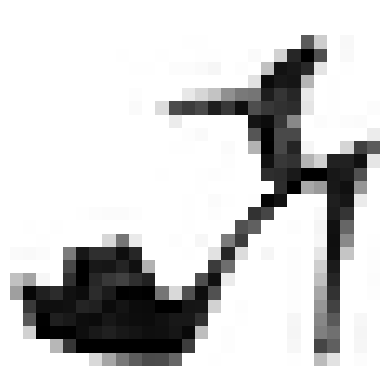

In [8]:
plt.imshow(cloth_image, cmap='binary')
plt.axis('off') #tira a grade da imagem
plt.show()

In [9]:
y[9]

'5'

In [10]:
y = y.astype(np.uint8) #Como algoritmos de ML precisam de números, convertemos y (string) para inteiro
#anotar na caixa de ferramentas

In [11]:
# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # divisão para mnist
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #USAR COMO PADRÃO (caso não tenha exceções nos dados)
#precisa ter o stratify=y para funcionar conforme o StratifiedKFold

In [12]:
# criamos um vetor-target 5 para distinguir entre 5 e não-5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) #necessário ter pois SGDC depende de  aleatoriedade nas classificações, por isso Estocástico. (Stochastic Gradient Decay)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [14]:
sgd_clf.predict([cloth]) # está classificando corretamente

array([ True])

In [15]:
#Como fazer uma validação cruzada com mais controle do que no cross_val_score:

#importar pacotes
from sklearn.model_selection import StratifiedKFold #divide os dados em partes (k) para treino e teste, garantindo a proporcionalidade em cada classe
from sklearn.base import clone #cria uma cópia limpa de um estimador ou modelo

In [16]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) # colocar na caixa de ferramentas

In [17]:
#skfolds.split está gerando arrays de numeros inteiros a cada iteração, dando a "coordenada" para quais linhas usar. Isso fatia nossos dados originais
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  #Clonamos o modelo de forma virgem, se não fizessemos isso, no fold 1 ele aprenderia os dados, e no fold 2 continuaria aprendendo em cima do que aprendeu no fold 1
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds) #estuda os dados para poder prever
    y_pred = clone_clf.predict(X_test_folds) # faz a predição
    n_correct = sum(y_pred == y_test_folds) #soma o numero de predições que acertaram
    print(n_correct / len(y_pred)) #print da % de acurácia para cada fold

0.9776075427224514
0.9690362672095141
0.9799099967855995


In [18]:
# como fazer com cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.97819682, 0.97492902, 0.97782064])

In [19]:
#matriz de confusão
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # definimos as predições para serem comparadas com os valores reais

In [20]:
from sklearn.metrics import confusion_matrix
cf_mtx = confusion_matrix(y_train_5, y_train_pred)
cf_mtx

array([[49714,   686],
       [  603,  4997]])

In [21]:
# cálculo manual
print("Precision:", cf_mtx[1, 1] / (cf_mtx[1, 1] + cf_mtx[0, 1]))
print("Recall:", cf_mtx[1, 1] / (cf_mtx[1, 1] + cf_mtx[1, 0]))

Precision: 0.8792891078655639
Recall: 0.8923214285714286


In [22]:
#cálculo automático do sklearn
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8792891078655639

In [23]:
recall_score(y_train_5, y_train_pred)

0.8923214285714286

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) #f1 score signfica a média harmônica das precisões e revocações, onde diferentemente da média normal, a média harmônica dá mais peso para valores baixos.

0.8857573340423647

In [25]:
# como escrito no caderno, as decisões que o SGDClassifier toma é a partir de scores, e com uma função de decisão ele adiciona a classificação. Com isso existem limiares, por isso vamos trazer os scores que o SGDC faz para cada instância
y_scores = sgd_clf.decision_function([cloth])
y_scores

array([36961.72060016])

In [26]:
threshold = 0 #o valor acima mostra qual o score de decisão da função, estamos testando como o limiar afeta a decisão
y_cloth_pred = (y_scores > threshold)
y_cloth_pred

array([ True])

In [27]:
threshold = 36962 #aqui, apenas 1 ponto acima do score de decisão mostra que a classificação perde um TP (true positive), onde prova que aumentar o limiar diminui a revocação.
y_cloth_pred = (y_scores > threshold)
y_cloth_pred

array([False])

In [28]:
# para decidir qual limiar utilizar, chamamos cross_val_predict com o method="decision_function". Com isso, teremos todos os scores de decisão de todas as instâncias da base de dados.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [29]:
# Para calcular precisão e revocação de todas as instâncias, usamos a funçao precision_recall_curve, apenas precisamos definir que precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

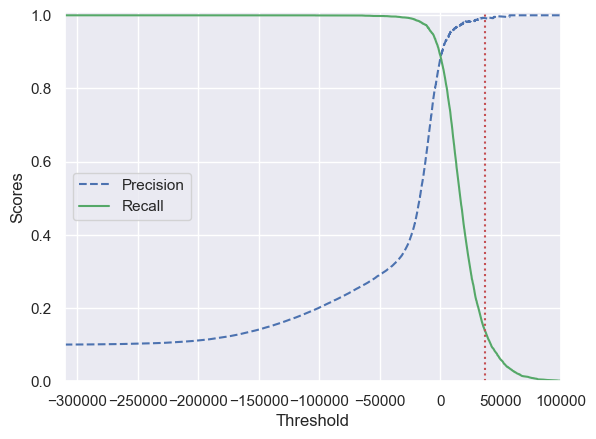

In [30]:
def plt_preci_recall_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--",label="Precision") # Utilizamos o [:-1] (slicing) para pegar todos os elementos, menos o último. o precision_recall_curve cria uma última precision ou recall igual a 0, sendo 1 a mais que o thresholds, para isso pegamos todos os elementos exceto o último.
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") #"b--" significa linha pontilhada azul e "g-" siginifica linha sólida verde
    # o autor não mostra como fazer o restante das configurações do plot, então inventei algumas para parecer com o plot do livro
    plt.legend(loc="center left") #ou outra como loc="best"
    plt.grid(True)

    plt.axvline(x=threshold, color='r', linestyle='dotted')
    #plt.axhline(y=threshold-1000, color='g', linestyle='dotted')

    plt.xlabel("Threshold") # Label normal
    plt.ylabel("Scores")
    plt.axis([-310000, 100000, 0, 1.01])

plt_preci_recall_thresholds(precisions, recalls, thresholds) #precisamos puxar os dados da função acima
plt.show()

In [31]:
# Se quisermos especificar uma % de precisão, podemos usar o seguinte código
threshold_90_preci = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_preci

np.float64(1543.935616638669)

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_preci)
precision_score(y_train_5, y_train_pred_90)

0.9000369549150037

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.8698214285714285

# Curva ROC

In [34]:
#a explicação de sensibilidade e especificidade foi feita no caderno, o ponto que iremos ver a seguir é sobre a plotagem dos TPRs (True positive rate) e dos FPRs (False positive rate).

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

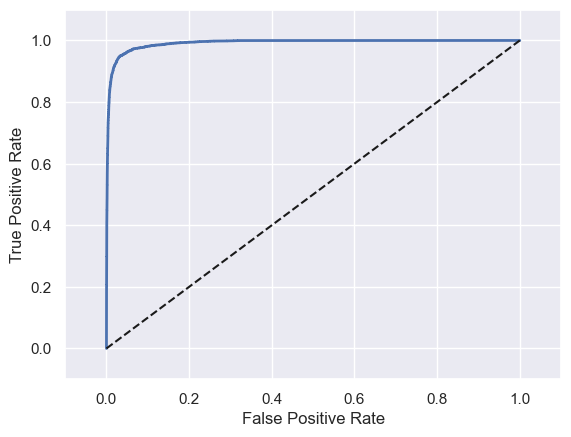

In [46]:
# fazemos uma função para poder plotar a curva ROC, da seguinte forma

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #diagonal tracejada
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9915081242913832

# RandomForestClassifier

In [41]:
#Devido ao modo como Random Forest funciona, o Classifier não tem um método decision_function(). Ele possui o predicit_proba()
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42) #define o modelo

In [42]:
    y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") # faz as probabilidades através da cross validation

In [43]:
y_scores_forest = y_probas_forest[:, 1] #score= probabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

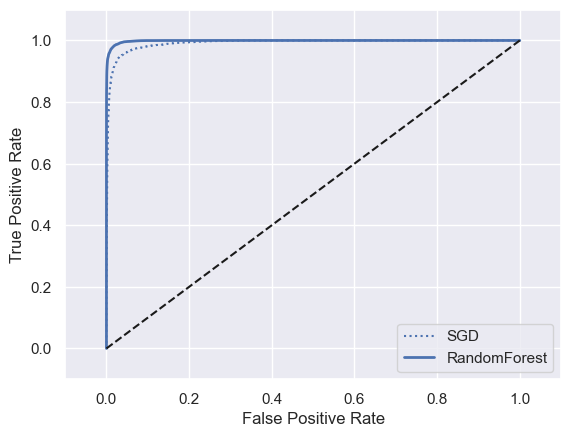

In [48]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.9988166595804988

In [60]:
y_train_pred_forest = (y_scores_forest >= 0.5)
precision_score(y_train_5, y_train_pred_forest)

0.9828701941377997

In [61]:
recall_score(y_train_5, y_train_pred_forest)

0.9221428571428572

In [62]:
confusion_matrix(y_train_5, y_train_pred_forest)

array([[50310,    90],
       [  436,  5164]])

ga# Classificação Multiclasse